<a href="https://colab.research.google.com/github/jasleenkaursandhu/Reproducing-chest-xray-report-generation-boag/blob/main/nlg_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Install necessary packages
!pip install pycocoevalcap

# Import necessary libraries
import numpy as np
import pandas as pd
import os
import sys
from collections import defaultdict
import tqdm
from time import strftime, gmtime
import matplotlib.pyplot as plt
import numpy as np

# Try to import evaluation metrics
try:
    from pycocoevalcap.bleu.bleu import Bleu
    from pycocoevalcap.cider.cider import Cider
    print("Successfully imported evaluation metrics from pycocoevalcap")
except ImportError:
    print("Failed to import from pycocoevalcap, trying alternative installation")
    # Alternative installation
    !git clone https://github.com/salaniz/pycocoevalcap
    !pip install -e pycocoevalcap
    from pycocoevalcap.bleu.bleu import Bleu
    from pycocoevalcap.cider.cider import Cider
    print("Successfully installed and imported metrics using alternative method")

# Mount Google Drive if in Colab
from google.colab import drive
drive.mount('/content/drive')

# Define paths
base_path = '/content/drive/MyDrive/mimic-cxr-project'
output_dir = os.path.join(base_path, 'output')

Successfully imported evaluation metrics from pycocoevalcap
Mounted at /content/drive


In [ ]:
# Evaluate random model with NLG metrics
print("Evaluating Random model with NLG metrics")

# Load reference and prediction files
df_gt = pd.read_csv(os.path.join(output_dir, 'reference.tsv'), sep='\t')
df_random = pd.read_csv(os.path.join(output_dir, 'random.tsv'), sep='\t')

print(f"Reference data shape: {df_gt.shape}")
print(f"Random predictions shape: {df_random.shape}")

# Convert to the format expected by the evaluation metrics
references = {k:[v] for k,v in df_gt[['dicom_id','text']].values}
pred_random = {k:[v] for k,v in df_random[['dicom_id','generated']].values}

# Find common IDs between reference and predictions
common_ids = set(references.keys()) & set(pred_random.keys())
print(f"Number of cases with both reference and prediction: {len(common_ids)}")

# Keep only common IDs
references_filtered = {k:references[k] for k in common_ids}
pred_random_filtered = {k:pred_random[k] for k in common_ids}

methods = {'random': pred_random_filtered}

# Calculate BLEU scores
print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))

for method, pred in methods.items():
    bleu_scorer = Bleu(4)
    bleu_score = bleu_scorer.compute_score(references_filtered, pred)
    print(f'\t{method:10} (n={len(pred):6d}): {bleu_score[0]}')

print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))

# Calculate CIDEr scores
print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))

for method, pred in methods.items():
    cider_scorer = Cider()
    cider_score = cider_scorer.compute_score(references_filtered, pred)
    print(f'\t{method:10} (n={len(pred):6d}): {cider_score[0]}')

print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))

Evaluating Random model with NLG metrics
Reference data shape: (349, 2)
Random predictions shape: (382, 2)
Number of cases with both reference and prediction: 349
2025-04-10 04:22:37
{'testlen': 18521, 'reflen': 18172, 'guess': [18521, 18172, 17824, 17476], 'correct': [4303, 972, 242, 65]}
ratio: 1.01920537090023
	random     (n=   349): [0.23233086766372052, 0.1114769878919848, 0.055257794615328315, 0.02814576070992964]
2025-04-10 04:22:37
2025-04-10 04:22:37
	random     (n=   349): 0.03755690090088168
2025-04-10 04:22:38


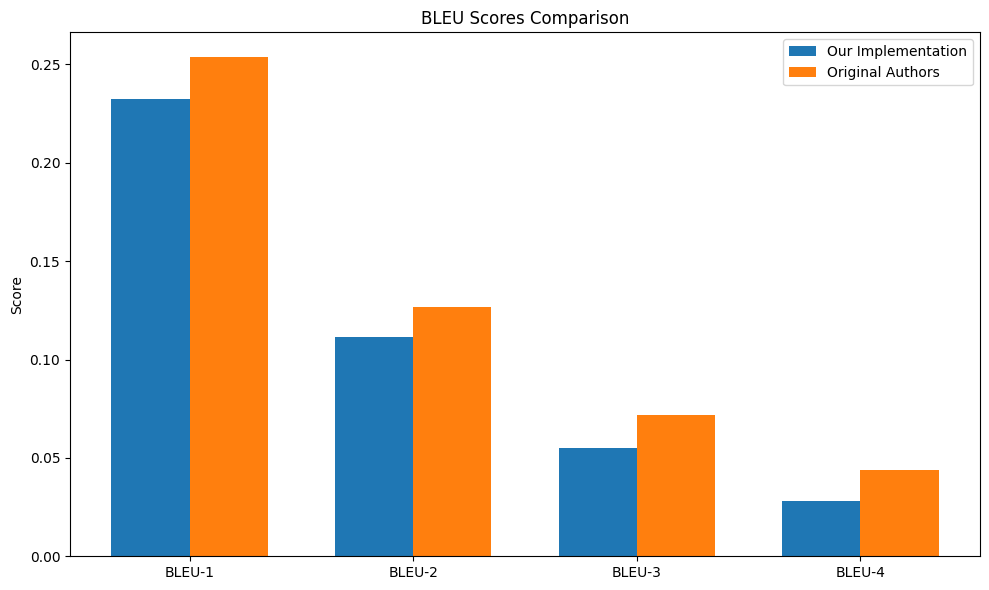

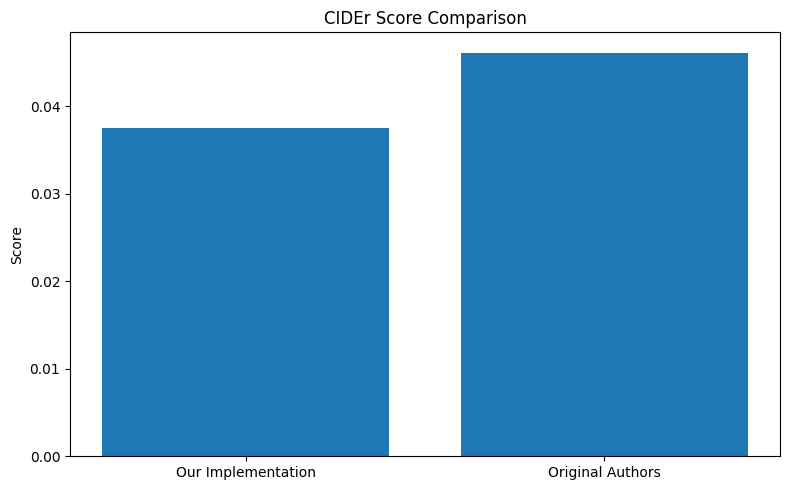

BLEU-1: Ours = 0.2323, Authors = 0.2536
BLEU-4: Ours = 0.0282, Authors = 0.0436
CIDEr:  Ours = 0.0376, Authors = 0.0462


In [ ]:
# Random model: Comparing our result to the authors.

# Our results
our_bleu = [0.23233, 0.11148, 0.05526, 0.02815]
our_cider = 0.03756

# Authors' results
authors_bleu = [0.25362, 0.12655, 0.07173, 0.04364]
authors_cider = 0.04617

# Create figure for BLEU scores
plt.figure(figsize=(10, 6))
width = 0.35
x = np.arange(4)

plt.bar(x - width/2, our_bleu, width, label='Our Implementation')
plt.bar(x + width/2, authors_bleu, width, label='Original Authors')

plt.ylabel('Score')
plt.title('BLEU Scores Comparison')
plt.xticks(x, ['BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4'])
plt.legend()

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/mimic-cxr-project/output/bleu_comparison.png')
plt.show()

# Create figure for CIDEr scores
plt.figure(figsize=(8, 5))
plt.bar(['Our Implementation', 'Original Authors'], [our_cider, authors_cider])
plt.ylabel('Score')
plt.title('CIDEr Score Comparison')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/mimic-cxr-project/output/cider_comparison.png')
plt.show()

# Print simple comparison
print("BLEU-1: Ours = {:.4f}, Authors = {:.4f}".format(our_bleu[0], authors_bleu[0]))
print("BLEU-4: Ours = {:.4f}, Authors = {:.4f}".format(our_bleu[3], authors_bleu[3]))
print("CIDEr:  Ours = {:.4f}, Authors = {:.4f}".format(our_cider, authors_cider))

In [ ]:
# Evaluate N-gram model with NLG metrics
print("Evaluating N-gram model with NLG metrics")

# Load 3-gram predictions
df_3gram = pd.read_csv(os.path.join(output_dir, '3-gram.tsv'), sep='\t')
print(f"3-gram predictions shape: {df_3gram.shape}")

# Convert to the format expected by evaluation metrics
pred_3gram = {k:[v] for k,v in df_3gram[['dicom_id','generated']].values}

# Find common IDs between reference and 3-gram predictions
common_ids_3gram = set(references.keys()) & set(pred_3gram.keys())
print(f"Number of cases with both reference and 3-gram prediction: {len(common_ids_3gram)}")

# Keep only common IDs
references_filtered_3gram = {k:references[k] for k in common_ids_3gram}
pred_3gram_filtered = {k:pred_3gram[k] for k in common_ids_3gram}

# Calculate BLEU scores for 3-gram model
print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))
bleu_scorer = Bleu(4)
bleu_score_3gram = bleu_scorer.compute_score(references_filtered_3gram, pred_3gram_filtered)
print(f"3-gram BLEU scores (n={len(pred_3gram_filtered)}): {bleu_score_3gram[0]}")

# Calculate CIDEr score for 3-gram model
cider_scorer = Cider()
cider_score_3gram = cider_scorer.compute_score(references_filtered_3gram, pred_3gram_filtered)
print(f"3-gram CIDEr score: {cider_score_3gram[0]}")
print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))

Evaluating N-gram model with NLG metrics
3-gram predictions shape: (380, 2)
Number of cases with both reference and 3-gram prediction: 347
2025-04-10 04:22:43
{'testlen': 16620, 'reflen': 18078, 'guess': [16620, 16273, 15927, 15581], 'correct': [3610, 814, 237, 57]}
ratio: 0.9193494855625114
3-gram BLEU scores (n=347): [0.19896533829483415, 0.0954811681449977, 0.04990189275137118, 0.025402879986777187]
3-gram CIDEr score: 0.022752264157837553
2025-04-10 04:22:43


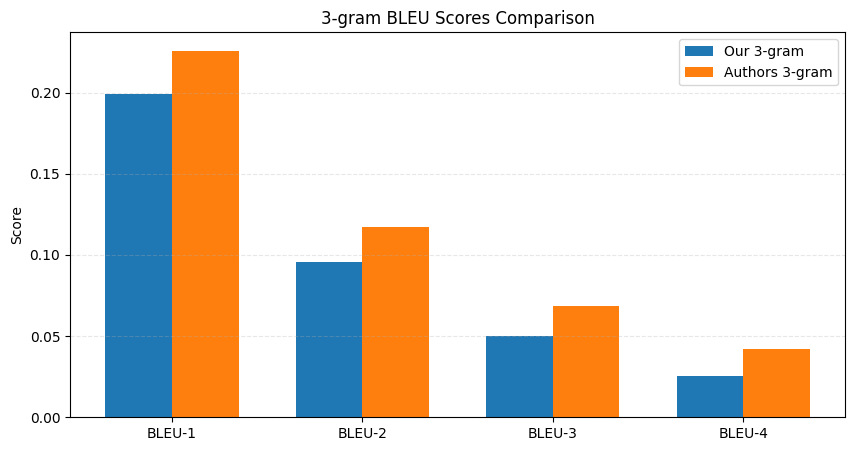

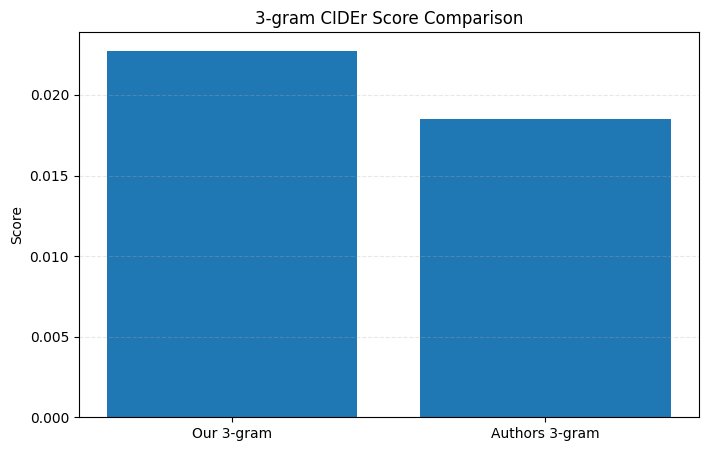

3-gram BLEU scores comparison:
  BLEU-1: Ours = 0.1990, Authors = 0.2258
  BLEU-2: Ours = 0.0955, Authors = 0.1172
  BLEU-3: Ours = 0.0499, Authors = 0.0687
  BLEU-4: Ours = 0.0254, Authors = 0.0418

3-gram CIDEr score comparison:
  Ours = 0.0227, Authors = 0.0185
2025-04-10 04:27:09


In [ ]:
# N-Gram model: Comparing our result to the authors.

# N-gram results
our_3gram_bleu = [0.19897, 0.09548, 0.04990, 0.02540]
our_3gram_cider = 0.02275

# Authors' n-gram results from the paper
authors_3gram_bleu = [0.22583, 0.11723, 0.06874, 0.04183]
authors_3gram_cider = 0.01850

# Create figure for BLEU scores
plt.figure(figsize=(10, 5))
width = 0.35
x = np.arange(4)

# Plot BLEU scores
plt.bar(x - width/2, our_3gram_bleu, width, label='Our 3-gram')
plt.bar(x + width/2, authors_3gram_bleu, width, label='Authors 3-gram')

plt.ylabel('Score')
plt.title('3-gram BLEU Scores Comparison')
plt.xticks(x, ['BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4'])
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.savefig(os.path.join(output_dir, 'ngram_bleu_comparison.png'))
plt.show()

# Create figure for CIDEr scores
plt.figure(figsize=(8, 5))
plt.bar(['Our 3-gram', 'Authors 3-gram'], [our_3gram_cider, authors_3gram_cider])
plt.ylabel('Score')
plt.title('3-gram CIDEr Score Comparison')
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.savefig(os.path.join(output_dir, 'ngram_cider_comparison.png'))
plt.show()

# Print numeric comparison
print("3-gram BLEU scores comparison:")
print(f"  BLEU-1: Ours = {our_3gram_bleu[0]:.4f}, Authors = {authors_3gram_bleu[0]:.4f}")
print(f"  BLEU-2: Ours = {our_3gram_bleu[1]:.4f}, Authors = {authors_3gram_bleu[1]:.4f}")
print(f"  BLEU-3: Ours = {our_3gram_bleu[2]:.4f}, Authors = {authors_3gram_bleu[2]:.4f}")
print(f"  BLEU-4: Ours = {our_3gram_bleu[3]:.4f}, Authors = {authors_3gram_bleu[3]:.4f}")

print("\n3-gram CIDEr score comparison:")
print(f"  Ours = {our_3gram_cider:.4f}, Authors = {authors_3gram_cider:.4f}")

print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))


In [5]:
# Evaluate KNN model with NLG metrics
print("Evaluating KNN model with NLG metrics")

# Load reference file if not already loaded
if 'df_gt' not in locals() or 'references' not in locals():
    # Load reference file (ground truth)
    df_gt = pd.read_csv(os.path.join(output_dir, 'reference.tsv'), sep='\t')
    print(f"Reference data shape: {df_gt.shape}")

    # Convert to the format expected by evaluation metrics
    references = {k:[v] for k,v in df_gt[['dicom_id','text']].values}
    print(f"Created references dictionary with {len(references)} entries")

# Load KNN predictions
df_knn = pd.read_csv(os.path.join(output_dir, 'knn.tsv'), sep='\t')
print(f"KNN predictions shape: {df_knn.shape}")

# Convert to the format expected by evaluation metrics
pred_knn = {k:[v] for k,v in df_knn[['dicom_id','generated']].values}

# Find common IDs between reference and KNN predictions
common_ids_knn = set(references.keys()) & set(pred_knn.keys())
print(f"Number of cases with both reference and KNN prediction: {len(common_ids_knn)}")

# Keep only common IDs
references_filtered_knn = {k:references[k] for k in common_ids_knn}
pred_knn_filtered = {k:pred_knn[k] for k in common_ids_knn}

# Calculate BLEU scores for KNN model
print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))
bleu_scorer = Bleu(4)
bleu_score_knn = bleu_scorer.compute_score(references_filtered_knn, pred_knn_filtered)
print(f"KNN BLEU scores (n={len(pred_knn_filtered)}): {bleu_score_knn[0]}")

# Calculate CIDEr score for KNN model
cider_scorer = Cider()
cider_score_knn = cider_scorer.compute_score(references_filtered_knn, pred_knn_filtered)
print(f"KNN CIDEr score: {cider_score_knn[0]}")
print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))

Evaluating KNN model with NLG metrics
Reference data shape: (349, 2)
Created references dictionary with 349 entries
KNN predictions shape: (380, 2)
Number of cases with both reference and KNN prediction: 347
2025-04-14 02:16:21
{'testlen': 17169, 'reflen': 18078, 'guess': [17169, 16822, 16475, 16128], 'correct': [4404, 987, 301, 118]}
ratio: 0.949717889146977
KNN BLEU scores (n=347): [0.24328140187457437, 0.11635298163126812, 0.06167382754357194, 0.03571928028970447]
KNN CIDEr score: 0.0720624947922381
2025-04-14 02:16:23


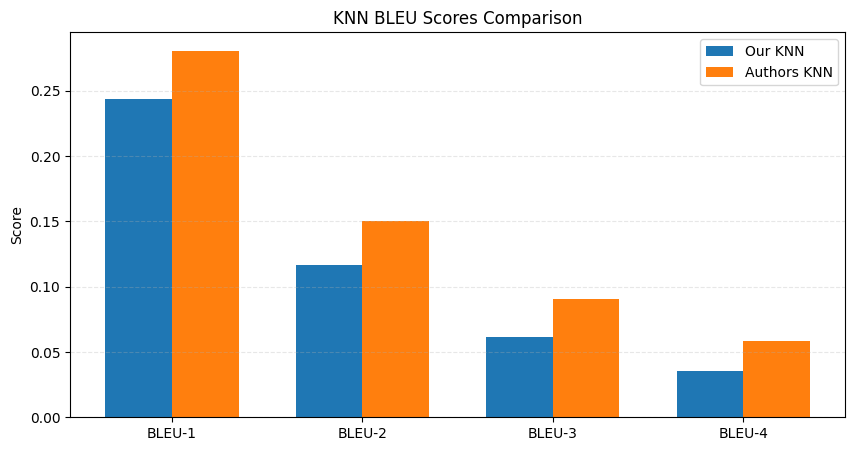

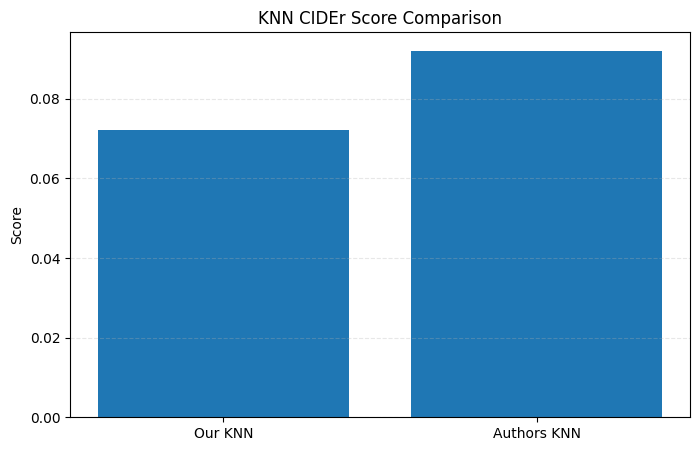

KNN BLEU scores comparison:
  BLEU-1: Ours = 0.2433, Authors = 0.2807
  BLEU-2: Ours = 0.1164, Authors = 0.1500
  BLEU-3: Ours = 0.0617, Authors = 0.0905
  BLEU-4: Ours = 0.0357, Authors = 0.0585

KNN CIDEr score comparison:
  Ours = 0.0721, Authors = 0.0921


In [6]:
# KNN model: Comparing our result to the authors.

# Our KNN results
our_knn_bleu = [0.2433, 0.1164, 0.0617, 0.0357]
our_knn_cider = 0.0721

# Authors' KNN results from the paper
authors_knn_bleu = [0.2807, 0.1500, 0.0905, 0.0585]
authors_knn_cider = 0.0921

# Create figure for BLEU scores
plt.figure(figsize=(10, 5))
width = 0.35
x = np.arange(4)

# Plot BLEU scores
plt.bar(x - width/2, our_knn_bleu, width, label='Our KNN')
plt.bar(x + width/2, authors_knn_bleu, width, label='Authors KNN')

plt.ylabel('Score')
plt.title('KNN BLEU Scores Comparison')
plt.xticks(x, ['BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4'])
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.savefig(os.path.join(output_dir, 'knn_bleu_comparison.png'))
plt.show()

# Create figure for CIDEr scores
plt.figure(figsize=(8, 5))
plt.bar(['Our KNN', 'Authors KNN'], [our_knn_cider, authors_knn_cider])
plt.ylabel('Score')
plt.title('KNN CIDEr Score Comparison')
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.savefig(os.path.join(output_dir, 'knn_cider_comparison.png'))
plt.show()

# Print numeric comparison
print("KNN BLEU scores comparison:")
print(f"  BLEU-1: Ours = {our_knn_bleu[0]:.4f}, Authors = {authors_knn_bleu[0]:.4f}")
print(f"  BLEU-2: Ours = {our_knn_bleu[1]:.4f}, Authors = {authors_knn_bleu[1]:.4f}")
print(f"  BLEU-3: Ours = {our_knn_bleu[2]:.4f}, Authors = {authors_knn_bleu[2]:.4f}")
print(f"  BLEU-4: Ours = {our_knn_bleu[3]:.4f}, Authors = {authors_knn_bleu[3]:.4f}")

print("\nKNN CIDEr score comparison:")
print(f"  Ours = {our_knn_cider:.4f}, Authors = {authors_knn_cider:.4f}")